# Generate test tensor and plot surface points

In [22]:
import plotly.graph_objects as go
import numpy as np
from scipy.ndimage import gaussian_filter, binary_erosion

tensor = np.zeros([100,100,100], dtype=np.int32)
tensor[10:20, 10:20, 10:20] = 1
#tensor[10:15,10:15,10:15] = 0
tensor[19:20,18:20,15:20] = 0 

tensor *= 10
tensor = gaussian_filter(tensor,1)
tensor = tensor > 1

x,y,z= np.array(np.where(np.logical_xor(tensor,binary_erosion(tensor))))
fig = go.Figure(data=go.Scatter3d(x=x, y=y,z=z, mode='markers'))
fig.show()

In [21]:
import plotly.graph_objects as go
import numpy as np
from scipy.ndimage import gaussian_filter, binary_erosion

tensor = np.zeros([10,10,10], dtype=np.int32)
tensor[5:8, 5:8, 5:7] = 1

x,y,z= np.array(np.where(np.logical_xor(tensor,binary_erosion(tensor))))
fig = go.Figure(data=go.Scatter3d(x=x, y=y,z=z, mode='markers'))
fig.show()

In [23]:
import math
import sys
from collections import namedtuple

Point = namedtuple('Point', ['x', 'y'])

EPSILON = math.sqrt(sys.float_info.epsilon)

def earclip(polygon):
    """
    Simple earclipping algorithm for a given polygon p.
    polygon is expected to be an array of 2-tuples of the cartesian points of the polygon
    For a polygon with n points it will return n-2 triangles.
    The triangles are returned as an array of 3-tuples where each item in the tuple is a 2-tuple of the cartesian point.
    e.g
    >>> polygon = [(0,1), (-1, 0), (0, -1), (1, 0)]
    >>> triangles = tripy.earclip(polygon)
    >>> triangles
    [((1, 0), (0, 1), (-1, 0)), ((1, 0), (-1, 0), (0, -1))]
    Implementation Reference:
        - https://www.geometrictools.com/Documentation/TriangulationByEarClipping.pdf
    """
    ear_vertex = []
    triangles = []

    polygon = [Point(*point) for point in polygon]

    if _is_clockwise(polygon):
        polygon.reverse()

    point_count = len(polygon)
    for i in range(point_count):
        prev_index = i - 1
        prev_point = polygon[prev_index]
        point = polygon[i]
        next_index = (i + 1) % point_count
        next_point = polygon[next_index]

        if _is_ear(prev_point, point, next_point, polygon):
            ear_vertex.append(point)

    while ear_vertex and point_count >= 3:
        ear = ear_vertex.pop(0)
        i = polygon.index(ear)
        prev_index = i - 1
        prev_point = polygon[prev_index]
        next_index = (i + 1) % point_count
        next_point = polygon[next_index]

        polygon.remove(ear)
        point_count -= 1
        triangles.append(((prev_point.x, prev_point.y), (ear.x, ear.y), (next_point.x, next_point.y)))
        if point_count > 3:
            prev_prev_point = polygon[prev_index - 1]
            next_next_index = (i + 1) % point_count
            next_next_point = polygon[next_next_index]

            groups = [
                (prev_prev_point, prev_point, next_point, polygon),
                (prev_point, next_point, next_next_point, polygon),
            ]
            for group in groups:
                p = group[1]
                if _is_ear(*group):
                    if p not in ear_vertex:
                        ear_vertex.append(p)
                elif p in ear_vertex:
                    ear_vertex.remove(p)
    return triangles


def _is_clockwise(polygon):
    s = 0
    polygon_count = len(polygon)
    for i in range(polygon_count):
        point = polygon[i]
        point2 = polygon[(i + 1) % polygon_count]
        s += (point2.x - point.x) * (point2.y + point.y)
    return s > 0


def _is_convex(prev, point, next):
    return _triangle_sum(prev.x, prev.y, point.x, point.y, next.x, next.y) < 0


def _is_ear(p1, p2, p3, polygon):
    ear = _contains_no_points(p1, p2, p3, polygon) and \
        _is_convex(p1, p2, p3) and \
        _triangle_area(p1.x, p1.y, p2.x, p2.y, p3.x, p3.y) > 0
    return ear


def _contains_no_points(p1, p2, p3, polygon):
    for pn in polygon:
        if pn in (p1, p2, p3):
            continue
        elif _is_point_inside(pn, p1, p2, p3):
            return False
    return True


def _is_point_inside(p, a, b, c):
    area = _triangle_area(a.x, a.y, b.x, b.y, c.x, c.y)
    area1 = _triangle_area(p.x, p.y, b.x, b.y, c.x, c.y)
    area2 = _triangle_area(p.x, p.y, a.x, a.y, c.x, c.y)
    area3 = _triangle_area(p.x, p.y, a.x, a.y, b.x, b.y)
    areadiff = abs(area - sum([area1, area2, area3])) < EPSILON
    return areadiff


def _triangle_area(x1, y1, x2, y2, x3, y3):
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2.0)


def _triangle_sum(x1, y1, x2, y2, x3, y3):
    return x1 * (y3 - y2) + x2 * (y1 - y3) + x3 * (y2 - y1)


def calculate_total_area(triangles):
    result = []
    for triangle in triangles:
        sides = []
        for i in range(3):
            next_index = (i + 1) % 3
            pt = triangle[i]
            pt2 = triangle[next_index]
            # Distance between two points
            side = math.sqrt(math.pow(pt2[0] - pt[0], 2) + math.pow(pt2[1] - pt[1], 2))
            sides.append(side)
        # Heron's numerically stable forumla for area of a triangle:
        # https://en.wikipedia.org/wiki/Heron%27s_formula
        # However, for line-like triangles of zero area this formula can produce an infinitesimally negative value
        # as an input to sqrt() due to the cumulative arithmetic errors inherent to floating point calculations:
        # https://people.eecs.berkeley.edu/~wkahan/Triangle.pdf
        # For this purpose, abs() is used as a reasonable guard against this condition.
        c, b, a = sorted(sides)
        area = .25 * math.sqrt(abs((a + (b + c)) * (c - (a - b)) * (c + (a - b)) * (a + (b - c))))
        result.append((area, a, b, c))
    triangle_area = sum(tri[0] for tri in result)
    return triangle_area

In [70]:
from collections import defaultdict
import numpy as np
from scipy.ndimage import gaussian_filter, binary_erosion

def bottom_plane(tensor, pos):
    return tensor[pos[0],pos[1],pos[2]-1] == 0#y,x,z

def top_plane(tensor, pos):
    return tensor[pos[0],pos[1],pos[2]+1] == 0

def left_plane(tensor, pos):
    return tensor[pos[0]-1,pos[1],pos[2]] == 0

def right_plane(tensor, pos):
    return tensor[pos[0]+1,pos[1],pos[2]] == 0

def back_plane(tensor, pos):
    return tensor[pos[0],pos[1]-1,pos[2]] == 0

def front_plane(tensor, pos):
    return tensor[pos[0],pos[1]+1,pos[2]] == 0

def left_border_pixel(array, pos):
    return array[pos[0], pos[1]-1] == 0

def right_border_pixel(array, pos):
    return array[pos[0], pos[1]+1] == 0

def top_border_pixel(array, pos):
    return array[pos[0]-1, pos[1]] == 0

def bottom_border_pixel(array, pos):
    return array[pos[0]+1, pos[1]] == 0

def get_outline(array, corners_only = False):
    outline = np.logical_xor(array,binary_erosion(array))

    where = np.array(np.where(outline))
    edge_type = np.ndarray(array.shape, dtype=object)
    coord = []
    for y, x in where.T:
        assert array[y,x] == True
        l = left_border_pixel(array, [y,x])
        r = right_border_pixel(array, [y,x])
        t = top_border_pixel(array, [y,x])
        b = bottom_border_pixel(array, [y,x])
        
        tl = t and l#upper left corner
        tr = t and r
        bl = b and l
        br = b and r
        
        edge_type[y][x] = []
        
        if tl:
            edge_type[y][x].append("tl")
        if tr:
            edge_type[y][x].append("tr")
        if bl:
            edge_type[y][x].append("bl")
        if br:
            edge_type[y][x].append("br")
                    
    trace = []
    y, x = where.T[0]
    trace_closed = False
    while True:
        outline[y,x] = 0
        edge = edge_type[y][x]

        if "bl" in edge:
            trace.append([y+0.5,x-0.5])#bottom left corner
        if "tl" in edge:
            trace.append([y-0.5,x-0.5])#top left corner
        if "tr" in edge:
            trace.append([y-0.5,x+0.5])#top right corner
        if "br" in edge:
            trace.append([y+0.5,x+0.5])#bottom right corner
        

        #Search for neighborig pixel
        if outline[y-1,x] == 1:#prefer going up
            y, x = [y-1,x]
            outline[y,x] = 0
            continue
        if outline[y-1,x+1] == 1:#prefer going up right
            trace.append([y-0.5,x+0.5])#top right corner
            y, x = [y-1,x+1]
            outline[y,x] = 0
            continue
        if outline[y,x+1] == 1:#prefer going right otherwise
            y, x = [y,x+1]
            outline[y,x] = 0
            continue
        if outline[y+1,x+1] == 1:#prefer going right down otherwise
            trace.append([y+0.5,x+0.5])#bottom right corner
            y, x = [y+1,x+1]
            outline[y,x] = 0
            continue
        if outline[y+1,x] == 1:#prefer going down otherwise
            y, x = [y+1,x]
            outline[y,x] = 0
            continue
        if outline[y+1,x-1] == 1:#prefer going down left otherwise
            trace.append([y+0.5,x-0.5])#bottom left corner
            y, x = [y+1,x-1]
            outline[y,x] = 0
            continue
        if outline[y,x-1] == 1:#prefer going left otherwise
            y, x = [y,x-1]
            outline[y,x] = 0
            continue
        if outline[y-1,x-1] == 1:#prefer left up
            trace.append([y-0.5,x-0.5])#top left corner
            y, x = [y-1,x-1]
            outline[y,x] = 0
            continue
        #no neighboring pixel, nowhere to go: Close trace
        if trace_closed == False:
            trace_closed = True
            y1, x1 = where.T[0]
            outline[y1,x1] = 1
            continue
        break#no neighboring pixel, nowhere to go
    trace.append(trace[0])
    trace = np.array(trace).T
    y = trace[0]
    x = trace[1]
    return x, y

In [71]:
def get_planes(tensor):
    surface = np.logical_xor(tensor,binary_erosion(tensor))
    
    top_voxels = np.zeros(tensor.shape, dtype=np.bool)
    bottom_voxels = np.zeros(tensor.shape, dtype=np.bool)
    left_voxels = np.zeros(tensor.shape, dtype=np.bool)
    right_voxels = np.zeros(tensor.shape, dtype=np.bool)
    back_voxels = np.zeros(tensor.shape, dtype=np.bool)
    front_voxels = np.zeros(tensor.shape, dtype=np.bool)

    for y, x, z in np.array(np.where(surface)).T:
        assert surface[y,x,z] == 1
        top_voxels[y,x,z] = top_plane(tensor, [y,x,z])
        bottom_voxels[y,x,z] = bottom_plane(tensor, [y,x,z])
        left_voxels[y,x,z] = left_plane(tensor, [y,x,z])
        right_voxels[y,x,z] = right_plane(tensor, [y,x,z])
        back_voxels[y,x,z] = back_plane(tensor, [y,x,z])
        front_voxels[y,x,z] = front_plane(tensor, [y,x,z])
        
    return top_voxels, bottom_voxels, left_voxels, right_voxels, back_voxels, front_voxels


def get_surfaces(tensor):
    top, bottom, left, right, back, front = get_planes(tensor)    
    xy_polygons = []
    xz_polygons = []
    yz_polygons = []

    _, _, zs = np.array(np.where(top))
    for current_z in list(set(zs)):
        plane = top[:,:,current_z]
        x, y = get_outline(plane)
        z = np.ndarray(len(x))
        z.fill(current_z+0.5)
        xy_polygons.append(np.array([x,y,z]))

    _, _, zs = np.array(np.where(bottom))
    for current_z in list(set(zs)):
        plane = bottom[:,:,current_z]
        x, y = get_outline(plane)
        z = np.ndarray(len(x))
        z.fill(current_z-0.5)
        xy_polygons.append(np.array([x,y,z]))

    _, xs, _ = np.array(np.where(back))
    for current_x in list(set(xs)):
        plane = back[:,current_x,:]
        z, y = get_outline(plane)
        x = np.ndarray(len(z))
        x.fill(current_x-0.5)
        xz_polygons.append(np.array([x,y,z]))
        
    _, xs, _ = np.array(np.where(front))
    for current_x in list(set(xs)):
        plane = front[:,current_x,:]
        z, y = get_outline(plane)
        x = np.ndarray(len(z))
        x.fill(current_x+0.5)
        xz_polygons.append(np.array([x,y,z]))
        
    ys, _, _ = np.array(np.where(left))
    for current_y in list(set(ys)):
        plane = left[current_y,:,:]
        z, x = get_outline(plane)
        y = np.ndarray(len(z))
        y.fill(current_y-0.5)
        yz_polygons.append(np.array([x,y,z]))
        
    ys, _, _ = np.array(np.where(right))
    for current_y in list(set(ys)):
        plane = right[current_y,:,:]
        z, x = get_outline(plane)
        y = np.ndarray(len(z))
        y.fill(current_y+0.5)
        yz_polygons.append(np.array([x,y,z]))
    polygons = [xy_polygons, xz_polygons, yz_polygons]
    return polygons

def polygon_plot(tensor, opacity=1.0, color='lightpink'):
    xy_polygons, xz_polygons, yz_polygons = get_surfaces(tensor)

    data = []

    for polygon in xz_polygons:
        for triangle in polygon_to_triangles(polygon, axis=0):
            y, x, z = triangle.T
            data.append(go.Mesh3d(x=x, y=y, z=z, color=color, opacity=opacity,i=[0],j=[1],k=[2]))
            
    for polygon in yz_polygons:
        for triangle in polygon_to_triangles(polygon, axis=1):
            y, x, z = triangle.T
            data.append(go.Mesh3d(x=x, y=y, z=z, color=color, opacity=opacity,i=[0],j=[1],k=[2]))
            
    for polygon in xy_polygons:
        for triangle in polygon_to_triangles(polygon, axis=2):
            y, x, z = triangle.T
            data.append(go.Mesh3d(x=x, y=y, z=z, color=color, opacity=opacity,i=[0],j=[1],k=[2]))
            
    return data

In [64]:
def polygon_to_triangles(coords,axis=0,method="earclip"):
    y,x,z = coords
    if not method == "earclip":
        raise NotImplemented("Only earclip is available")

    if axis == 0:
        assert np.all(y==y[0])
        polygon = np.array([x,z]).T
        triangles = np.array(earclip(polygon))
        triangles = np.insert(triangles,0, y[0], axis=2)
        return triangles
    
    if axis == 1:
        assert np.all(x==x[0])
        polygon = np.array([y,z]).T
        triangles = np.array(earclip(polygon))
        triangles = np.insert(triangles,1, x[0], axis=2)
        return triangles
    
    elif axis == 2:
        assert np.all(z==z[0])
        polygon = np.array([y,x]).T
        triangles = np.array(earclip(polygon))
        triangles = np.insert(triangles,2, z[0], axis=2)
        return triangles

In [72]:
import plotly.graph_objects as go
import numpy as np

data = polygon_plot(tensor, color="blue")

x, y, z = [[],[],[]]
polygons = get_surfaces(tensor)
for poly in polygons:
    for p in poly:
        cx, cy, cz = p
        x.extend(cx)
        y.extend(cy)
        z.extend(cz)
#data.append(go.Scatter3d(x=x, y=y, z=z, mode='markers'))

fig = go.Figure(data=data)
fig.show()

In [66]:
x = np.array([ 9.5, 19.50, 19.5])
y = np.array([19.5, 19.5, 19.5])
z = np.array([ 9.5,  9.5, 19.5])

data = [go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, delaunayaxis='y')]

In [67]:
data = polygon_plot(tensor, color="blue")

AxisError: axis 2 is out of bounds for array of dimension 1

# Test get_surfaces

In [68]:
np.where(top)

ValueError: could not broadcast input array from shape (3,12) into shape (3)

In [69]:
left, back, top = get_surfaces(tensor)
data = []
for y,x,z in left:
    data.append(go.Scatter3d(x=x, y=y, z=z, mode='lines'))
    data.append(go.Scatter3d(x=x, y=y, z=z, mode='lines'))
    data.append(go.Scatter3d(x=x, y=y, z=z, mode='lines'))
    
#x,y,z= np.array(np.where(np.logical_xor(tensor,binary_erosion(tensor))))

top_voxels, bottom_voxels, left_voxels, right_voxels, back_voxels, front_voxels = get_planes(tensor)


x,y,z= np.array(np.where(top_voxels))
data.append(go.Scatter3d(x=x, y=y,z=z, mode='markers'))

x,y,z= np.array(np.where(bottom_voxels))
data.append(go.Scatter3d(x=x, y=y,z=z, mode='markers'))

"""
x,y,z= np.array(np.where(left_voxels))
data.append(go.Scatter3d(x=x, y=y,z=z, mode='markers'))

x,y,z= np.array(np.where(right_voxels))
data.append(go.Scatter3d(x=x, y=y,z=z, mode='markers'))

x,y,z= np.array(np.where(front_voxels))
data.append(go.Scatter3d(x=x, y=y,z=z, mode='markers'))

x,y,z= np.array(np.where(back_voxels))
data.append(go.Scatter3d(x=x, y=y,z=z, mode='markers'))"""

"""for y,x,z in left:
    data.append(go.Scatter3d(x=x, y=y, z=z, mode='lines'))
    data.append(go.Scatter3d(x=x, y=y, z=z, mode='lines'))
    data.append(go.Scatter3d(x=x, y=y, z=z, mode='lines'))
    
    
for y,x,z in back:
    data.append(go.Scatter3d(x=x, y=y, z=z, mode='lines'))
    data.append(go.Scatter3d(x=x, y=y, z=z, mode='lines'))
    data.append(go.Scatter3d(x=x, y=y, z=z, mode='lines'))"""
    
fig = go.Figure(data=data)
fig.show()

In [4]:
triangles = polygon_to_triangles(polygon, axis =2)

NameError: name 'polygon' is not defined

In [5]:
for tri in earclip(simple2d):
    plt.plot(*np.array(tri).T)
    print(*np.array(tri).T)

NameError: name 'earclip' is not defined

In [6]:
polygon_to_triangles

<function __main__.polygon_to_triangles(coords, axis=0, method='earclip')>

In [7]:
triangles = np.insert(testx, 0, 42, axis=2)

NameError: name 'testx' is not defined

# Test get outline

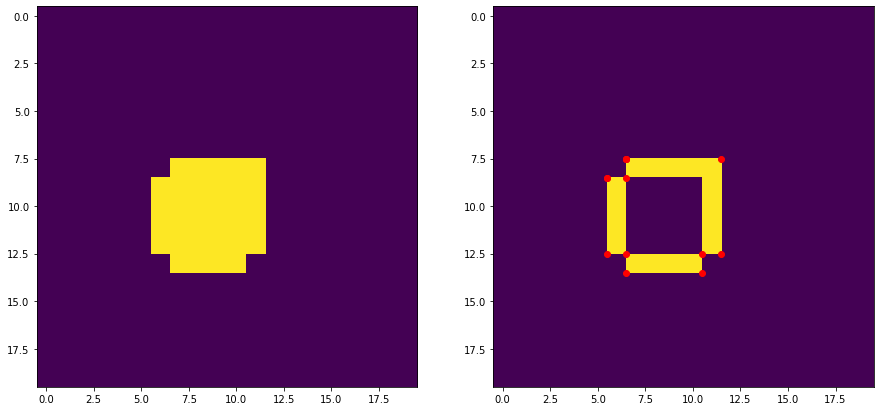

In [9]:
import matplotlib.pyplot as plt

test_array = np.zeros([20,20])
test_array[8:14,6:12] = 1
test_array[8:9,6] = 0
test_array[13,11] = 0
test_array[13,6]= 0

x, y = get_outline(test_array)

fig,ax=plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(test_array)
ax[1].imshow(np.logical_xor(test_array,binary_erosion(test_array)))
plt.scatter(x, y, color ="r")

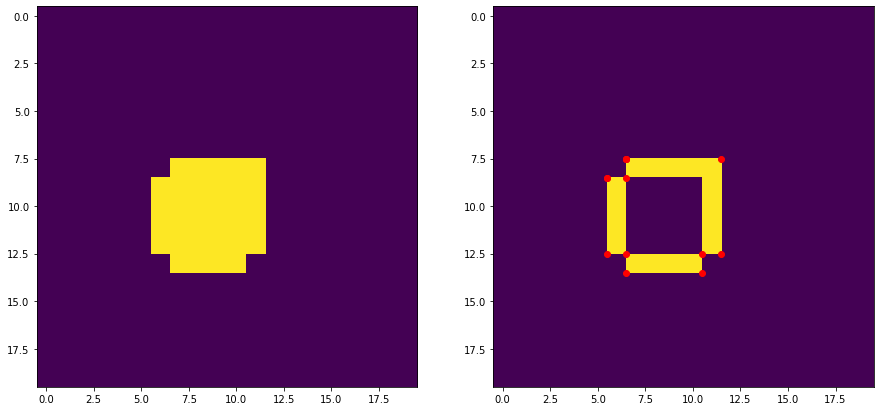

In [10]:
import matplotlib.pyplot as plt

test_array = np.zeros([20,20])
test_array[8:14,6:12] = 1
test_array[8:9,6] = 0
test_array[13,11] = 0
test_array[13,6]= 0

x, y = get_outline(test_array)

fig,ax=plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(test_array)
ax[1].imshow(np.logical_xor(test_array,binary_erosion(test_array)))
plt.scatter(x, y, color ="r")

# Plot surface points 

In [29]:
example = polygons[0][0]#Example polygon where axis 1 is all 9.5

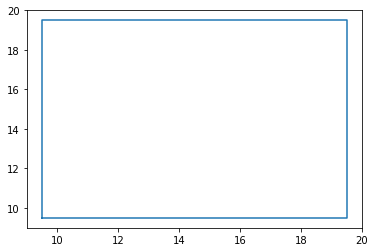

In [30]:
plt.plot(example[0], example[1])

In [32]:
np.array([example[0], example[1]]).T

array([[ 9.5,  9.5],
       [19.5,  9.5],
       [19.5, 19.5],
       [ 9.5, 19.5],
       [ 9.5,  9.5]])

In [34]:
polygon_to_triangles(np.array([example[0], example[1]]).T)

[((9.5, 9.5), (19.5, 9.5), (19.5, 19.5)),
 ((9.5, 9.5), (19.5, 19.5), (9.5, 19.5)),
 ((9.5, 9.5), (9.5, 19.5), (9.5, 9.5))]

In [62]:
set(example[0])

{9.5, 19.5}

In [63]:
set(example[1])

{9.5, 19.5}

In [55]:
polygons

[[array([[ 9.5, 19.5, 19.5,  9.5,  9.5],
         [ 9.5,  9.5, 19.5, 19.5,  9.5],
         [19.5, 19.5, 19.5, 19.5, 19.5]]),
  array([[14.5, 19.5, 19.5,  9.5,  9.5, 14.5],
         [ 9.5,  9.5, 19.5, 19.5, 14.5,  9.5],
         [ 9.5,  9.5,  9.5,  9.5,  9.5,  9.5]]),
  array([[ 9.5, 14.5, 14.5,  9.5,  9.5],
         [ 9.5,  9.5, 14.5, 14.5,  9.5],
         [14.5, 14.5, 14.5, 14.5, 14.5]])],
 [array([[ 9.5,  9.5,  9.5,  9.5,  9.5,  9.5],
         [14.5, 19.5, 19.5,  9.5,  9.5, 14.5],
         [ 9.5,  9.5, 19.5, 19.5, 14.5,  9.5]]),
  array([[14.5, 14.5, 14.5, 14.5, 14.5],
         [ 9.5, 14.5, 14.5,  9.5,  9.5],
         [ 9.5,  9.5, 14.5, 14.5,  9.5]]),
  array([[19.5, 19.5, 19.5, 19.5, 19.5],
         [ 9.5, 19.5, 19.5,  9.5,  9.5],
         [ 9.5,  9.5, 19.5, 19.5,  9.5]])],
 [array([[14.5, 19.5, 19.5,  9.5,  9.5, 14.5],
         [ 9.5,  9.5,  9.5,  9.5,  9.5,  9.5],
         [ 9.5,  9.5, 19.5, 19.5, 14.5,  9.5]]),
  array([[ 9.5, 14.5, 14.5,  9.5,  9.5],
         [14.5, 14.5, 14.5, 

In [1755]:
points = [polygons[0][2][1],polygons[0][2][2]]

In [1756]:
len(sims)

46

In [1757]:
from scipy.spatial import Delaunay
tri = Delaunay(points)
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1],  tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 15)

While executing:  | qhull d Qz Q12 Qbb Qc Qx Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 327302616  delaunay  Qz-infinity-point  Q12-allow-wide  Qbbound-last
  Qcoplanar-keep  Qxact-merge  Qtriangulate  _zero-centrum  Qinterior-keep
  Q3-no-merge-vertices-dim-high  _maxoutside  0


In [101]:
from scipy import ndimage
tensor = np.zeros([100,100,100], dtype=np.int32)
tensor[10:21,10:21,10:21] = 1

top, bottom, left, right, back, front = get_planes(tensor)

assert bottom_plane(tensor, [11,11,10])
assert top_plane(tensor, [15,10,20])
assert left_plane(tensor, [10,14,13])
assert right_plane(tensor, [20,15,11])
assert front_plane(tensor, [15,20,17])
assert back_plane(tensor, [14,10,14])

In [1493]:
top, bottom, left, right, back, front = get_planes(tensor)

In [1494]:
x, y, z = [[],[],[]]

for poly in polygons:
    cx, cy, cz = poly
    x.extend(cx)
    y.extend(cy)
    z.extend(cz)

In [1271]:
y, x, z  = np.array(np.where(top))

# Binary structuring elements

In [1218]:
x

[9.5,
 9.5,
 10.5,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 19.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 19.5,
 19.0,
 18.0,
 17.0,
 16.0,
 15.0,
 14.0,
 13.0,
 12.0,
 11.0,
 10.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 10.5,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 19.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 20.5,
 19.5,
 19.0,
 18.0,
 17.0,
 16.0,
 15.0,
 14.0,
 13.0,
 12.0,
 11.0,
 10.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 9.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,
 10.5,

In [836]:
outline = np.logical_xor(test_array,binary_erosion(test_array))


In [852]:
hit = np.array([[0, 0, 0], 
                [0, 0, 1], 
                [0, 1, 0]])

miss = np.array([[0, 0, 0], 
                 [0, 1, 0], 
                 [0, 0, 1]])

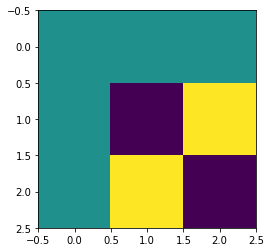

In [853]:
plt.imshow(hit-miss)

In [31]:
from scipy.ndimage import convolve, binary_hit_or_miss

In [32]:
hm = binary_hit_or_miss(outline, structure1=hit, structure2 = miss, origin1=1)
plt.imshow(hm)


NameError: name 'outline' is not defined

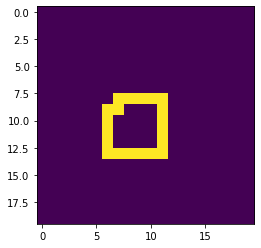

In [856]:
plt.imshow(outline+hm)

In [965]:
x, y, z  = np.array(np.where(top))